In [ ]:
!git clone https://github.com/minjae0501/LSTM_Lecture.git

Cloning into 'LSTM_Lecture'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 550 (delta 2), reused 10 (delta 0), pack-reused 536
Receiving objects: 100% (550/550), 275.52 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%pip install mediapipe
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 27.0/166.8 GB disk)


In [ ]:
import cv2
import mediapipe as mp
from ultralytics import YOLO
import numpy as np

### dataset

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

yolo_best_model = '/content/LSTM_Lecture/model/YOLO_best.pt'
yolo_model = YOLO(yolo_best_model)

def show_hand(video_path, detect_cls, hand_cls):
  xyz_list_list = []
  hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.3)

  cap = cv2.VideoCapture(video_path)
  if cap.isOpened():
    # cnt = 0
    while True:
      ret, img = cap.read()
      if ret == True:
      # if cnt == interval and ret == True:
        # cnt = 0
        xyz_list = []
        img = cv2.resize(img, (640,640))
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        #Hand_landmarks
        if not results.multi_hand_landmarks:
          continue

        for x_y_z in results.multi_hand_landmarks:
          for landmark in x_y_z.landmark:
            xyz_list.append(landmark.x)
            xyz_list.append(landmark.y)
            xyz_list.append(landmark.z)


        # YOLO 박스
        box_results = yolo_model.predict(img, conf = 0.6,  verbose=False, show = False)
        box_results = box_results[0].boxes

        boxes = box_results.xyxy.cpu().tolist()
        box_class = box_results.cls.cpu().tolist()


        # YOLO 박스 좌표
        x1, y1, x2, y2 = 0,0,0,0 #객체 좌표 초기화
        hx1, hy1, hx2, hy2 = 0,0,0,0 #손 좌표 초기화
        for idx, cls in enumerate(box_class):
          if int(cls) == detect_cls:
            x1, y1, x2, y2 = boxes[idx]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

          elif int(cls) == hand_cls:
            hx1, hy1, hx2, hy2 = boxes[idx]
            hx1, hy1, hx2, hy2 = int(hx1), int(hy1), int(hx2), int(hy2)

        # Block과 hand가 detect되어 있을 때만 dataset append
        if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
          continue
        if hx1 == 0 and hy1 == 0 and hx2 == 0 and hy2 == 0:
          continue

        # Block과 hand의 좌표 값을 빼주어 거리를 나타내줌
        xyz_list.append(abs(x1-hx1)/640)
        xyz_list.append(abs(x2-hx2)/640)
        xyz_list.append(abs(y1-hy1)/640)
        xyz_list.append(abs(y2-hy2)/640)

        # dataset append
        xyz_list_list.append(xyz_list)

        cv2.waitKey(1)
      elif ret == False:
        break
  cap.release()
  return xyz_list_list

In [ ]:
import os
import random

video_path = '/content/LSTM_Lecture/data/LSTM_data/train'
video_name_list = os.listdir(video_path)
dataset = []
length = 20
detect_cls = 0
hand_cls = 1

for video_name in video_name_list:
  if 'release' in video_name: label = 0
  else: label = 1
  hand_data = show_hand('{}/{}'.format(video_path, video_name),detect_cls, hand_cls)
  for idx in range(0, len(hand_data), int(length)):
    seq_list = hand_data[idx : idx + length]
    if len(seq_list) == length:
      dataset.append({'key': label, 'value' : seq_list})

random.shuffle(dataset)

In [ ]:
print(len(dataset))

193


In [ ]:
print('input data', dataset[0]['value'][0])
print("input data length: ",len(dataset[0]['value'][0]))

input data [0.44002336263656616, 0.733805239200592, 5.018625870434335e-07, 0.3892795145511627, 0.6386224031448364, -0.08617778867483139, 0.360355019569397, 0.5476943254470825, -0.0778140276670456, 0.32745951414108276, 0.4709816873073578, -0.04604235664010048, 0.2958803176879883, 0.40849265456199646, -0.003586971666663885, 0.46934324502944946, 0.4790123403072357, 0.016310276463627815, 0.43697285652160645, 0.3707321882247925, 0.05128253623843193, 0.41304534673690796, 0.3135547637939453, 0.06477143615484238, 0.3940662443637848, 0.2629336714744568, 0.07149505615234375, 0.46000951528549194, 0.4933830499649048, 0.08174483478069305, 0.4281834661960602, 0.39791083335876465, 0.1303338259458542, 0.3986305892467499, 0.345450222492218, 0.1353154480457306, 0.3784968852996826, 0.3117482662200928, 0.1314721703529358, 0.4402284026145935, 0.5140716433525085, 0.13559839129447937, 0.3889004588127136, 0.44872188568115234, 0.16250468790531158, 0.3482605516910553, 0.452771931886673, 0.14142422378063202, 0.3

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [ ]:
# train, val, test split
split_ratio = [0.7, 0.2, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len

In [ ]:
from torch.utils.data import random_split

train_dataset = MyDataset(dataset)
train_data, vaild_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=8)
val_loader = DataLoader(vaild_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

### LSTM_Train

In [ ]:
if torch.cuda.is_available() == True:
    device = 'cuda:0'
else:
    device = 'cpu'

print(device)

cuda:0


In [ ]:
# LSTM모델
class hand_LSTM(nn.Module):
    def __init__(self, num_layers=1):
        super(hand_LSTM, self).__init__()
        """
        LayerNorm(): RNN과 LSTM에 적합
        - LSTM과 같은 순환 신경망에서는 시간에 따른 의존성 때문에 배치 정규화가 잘 작동하지 않을 수 있다.
        - 반면 레이어 정규화는 시간적 의존성에 영향을 받지 않아 RNN과 LSTM에 더 적합하다.
        """
        # bidirectional -> 양방향 lstm: 시퀀스 데이터를 순방향과 역방향 모두 학습
        self.lstm1 = nn.LSTM(67, 128, num_layers, batch_first=True, bidirectional=True)
        # lstm layer 정규화 사용, 양방향이기 때문에 256개
        self.layer_norm1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(0.1)

        self.lstm2 = nn.LSTM(256, 64, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(0.1)

        self.lstm3 = nn.LSTM(128, 32, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm3 = nn.LayerNorm(64)
        self.dropout3 = nn.Dropout(0.1)

        self.attention = nn.Linear(64, 1)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.layer_norm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.layer_norm2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)
        x = self.layer_norm3(x)
        x = self.dropout3(x)

        # Attention 메커니즘
        attention_weights = torch.softmax(self.attention(x), dim=1)
        x = torch.sum(attention_weights * x, dim=1)

        x = self.fc(x)
        return x

In [ ]:
import matplotlib.pyplot as plt
from torch.optim import Adam

# init_model: model, loss_function, optim 선언
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = hand_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr = 0.001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    global iter_log, tloss_log, tacc_log, vloss_log, vacc_log, log_stack, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [],[],[],[],[]
    log_stack, time_log = [], []

In [ ]:
def record_train_log(_tloss, _tacc, _time):
    # train log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # validation log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) -1]
    else:
        return -1

from IPython.display import clear_output

def print_log():
    # 학습 추이 출력

    # 소숫점 3자리 수까지 조절
    trian_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5}| V_Loss {:5}| V_acc {:5} | {:5}'.format(last(iter_log), trian_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) #프린트 준비

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize= (10, 3), dpi = 99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정

    # loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color= 'red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color= 'blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line #위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [ ]:
import gc
from torch.cuda import empty_cache

def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'trian'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration학습 알고리즘(for문 나오면 1epoch완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        if mode == 'train':
            net.train()
        else:
            net.eval()

        result = net(data)
        _, out = torch.max(result, 1)

        # 2. loss 계산
        loss = loss_fn(result, label)
        iter_loss.append(loss.item())

        # 3. 역전파 학습후 gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # gradient Descent수행
            last_grad_performed = True #for문 나가면 epoch카운터 +=1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())
    # 역전파 학습 후 epoch카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # epoch이 끝남을 알림
    return epoch_cnt < maximum_epoch

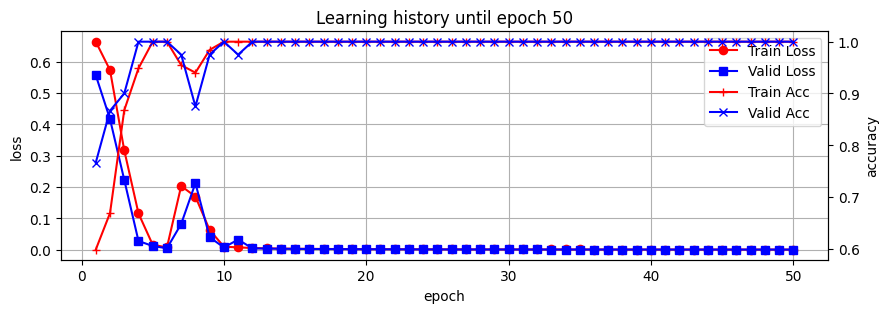

Epoch:  50 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.385
Epoch:  49 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.375
Epoch:  48 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.366
Epoch:  47 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.373
Epoch:  46 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.375
Epoch:  45 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.366
Epoch:  44 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.375
Epoch:  43 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 |  0.37
Epoch:  42 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.366
Epoch:  41 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 |  0.37
Epoch:  40 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.378
Epoch:  39 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.371
Epoch:  38 | T_Loss   0.0 | T_acc   1.0| V_Loss   0.0| V_acc   1.0 | 0.371
Epoch:  37 | T_Loss   0.0

In [ ]:
# training initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 50

# training iteration
import time

while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad(): # 역전파 학습을 하지 말도록
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [ ]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc: 1.0
Test Loss: 0.0003


In [ ]:
# 모델을 저장할 파일 경로
model_path = '/content/lstm_model.pth'

# 모델 저장
torch.save(net.state_dict(), model_path)
print("모델이 저장되었습니다.")

모델이 저장되었습니다.


####Try Apply

In [ ]:
# 모델 불러오기
# model_path = '/content/LSTM_Lecture/model/lstm_model.pth'
model_path = '/content/lstm_model.pth'


lstm_model = hand_LSTM().to(device)
lstm_model.load_state_dict(torch.load(model_path, map_location=device))
lstm_model.eval()
print("모델이 성공적으로 불러와졌습니다.")

모델이 성공적으로 불러와졌습니다.


In [ ]:
# YOLO 객체 감지 모델 초기화
yolo_best_model = '/content/LSTM_Lecture/model/YOLO_best.pt'
yolo_model = YOLO(yolo_best_model)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [ ]:
video_path = '/content/LSTM_Lecture/data/LSTM_data/test/test.mp4'

cap = cv2.VideoCapture(video_path)
img_list = []
if cap.isOpened():
    cnt = 0
    while True:
        ret , img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
        else: break

cap.release()

print('저장된 frame의 개수 {}'.format(len(img_list)))

저장된 frame의 개수 674


In [ ]:
from tqdm import tqdm

length = 20
detect_cls = 0
hand_cls = 1

lstm_model.eval()
out_img_list = []
dataset = []
status = 'None'

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.3)
mp_drawing = mp.solutions.drawing_utils

print('시퀀스 데이터 분석 중..')
xyz_list_list = []

for img in tqdm(img_list):
    results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    xyz_list = []

    if not results.multi_hand_landmarks:
          continue

    for x_y_z in results.multi_hand_landmarks:
          for landmark in x_y_z.landmark:
            xyz_list.append(landmark.x)
            xyz_list.append(landmark.y)
            xyz_list.append(landmark.z)

          mp_drawing.draw_landmarks(img, x_y_z, mp_hands.HAND_CONNECTIONS)

    # YOLO 박스
    box_results = yolo_model.predict(img, conf = 0.6,  verbose=False, show = False)
    box_results = box_results[0].boxes

    boxes = box_results.xyxy.cpu().tolist()
    box_class = box_results.cls.cpu().tolist()

    # YOLO 박스 좌표
    x1, y1, x2, y2 = 0, 0, 0, 0
    hx1, hy1, hx2, hy2 = 0,0,0,0
    for idx, cls in enumerate(box_class):
        if int(cls) == detect_cls:
            x1, y1, x2, y2 = boxes[idx]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        elif int(cls) == hand_cls:
            hx1, hy1, hx2, hy2 = boxes[idx]
            hx1, hy1, hx2, hy2 = int(hx1), int(hy1), int(hx2), int(hy2)
            cv2.rectangle(img, (hx1, hy1), (hx2, hy2), (0, 0, 255), 2)

    if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
          continue
    if hx1 == 0 and hy1 == 0 and hx2 == 0 and hy2 == 0:
          continue

    xyz_list.append(abs(x1-hx1)/640)
    xyz_list.append(abs(x2-hx2)/640)
    xyz_list.append(abs(y1-hy1)/640)
    xyz_list.append(abs(y2-hy2)/640)

    xyz_list_list.append(xyz_list)

    if len(xyz_list_list) == length:
        dataset = []
        dataset.append({'key': 0, 'value': xyz_list_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        xyz_list_list = []
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = lstm_model(data)
                _, out = torch.max(result, 1)
                if out.item() == 0: status = 'Release'
                else: status = 'Grab'

    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255 ,0, 0), 2)
    out_img_list.append(img)

시퀀스 데이터 분석 중..


100%|██████████| 674/674 [00:16<00:00, 40.67it/s]


In [ ]:
filename = '/content/video_out.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
frameSize = (640,640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)

out.release()